<a href="https://colab.research.google.com/github/Moukthika1253/NaiveBayesClassifier-Rotten-Tomato-reviews/blob/main/NBC_Rotten_tomato_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import string,re
import nltk
from nltk import word_tokenize
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import defaultdict
from nltk.stem import PorterStemmer
import math

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
rt_df=pd.read_csv('/content/rt_reviews.csv',encoding='latin-1')

# Splitting data into Train-50%, Dev-20%, Test-30%

In [3]:
X_train,X_remaining, y_train, y_remaining= train_test_split(rt_df['Review'],rt_df['Freshness'],train_size=0.5)
X_test, X_dev, y_test, y_dev = train_test_split(X_remaining,y_remaining,test_size=0.3)
train_set=pd.concat([X_train,y_train],axis=1).reset_index(drop=True)
dev_set=pd.concat([X_dev,y_dev],axis=1).reset_index(drop=True)
test_set=pd.concat([X_test,y_test],axis=1).reset_index(drop=True)
print(f"Train set size:  ",train_set.size)
print(f"Dev set size:  ",dev_set.size)
print(f"Test set size:  ",test_set.size)

Train set size:   480000
Dev set size:   144000
Test set size:   336000


In [5]:
train_set.head()

,Review,Freshness
0,First-time film director Susan Stroman has be...,rotten
1,"[Philippe] Falardeau's unobtrusive direction,...",fresh
2,For much of its running time The Invasion is ...,fresh
3,Woody Allen revisits familiar themes in matur...,fresh
4,Foxx is worth the price of admission.,fresh


# Pre-processing

In [4]:
def preprocessing(review):
  stop_words=stopwords.words('english')
  word_lemmatizer=WordNetLemmatizer()
  tokenized_words=[(word) for word in word_tokenize(review)]
  words=[word.lower() for word in tokenized_words if word.lower() not in stop_words]
  for i in range(len(words)):
   words[i]=''.join([word for word in words[i] if word not in (string.punctuation)])
  no_emptywords=[word for word in words if word]
  no_extraspace=[re.sub(r'\s\s+', '',word) for word in no_emptywords]
  lemmatized_words=[word_lemmatizer.lemmatize(word) for word in no_extraspace]
  return lemmatized_words 
  

In [ ]:
train_set['Review']=train_set['Review'].apply(preprocessing)
train_set.head()

,Review,Freshness
0,"[siegel, s, directorial, debut, real, ring, tr...",fresh
1,"[director, werner, herzog, s, latest, cinemati...",fresh
2,"[david, mackenzie, s, fourth, feature, immense...",fresh
3,"[turistas, nt, much, going, beyond, xenophobic...",rotten
4,"[international, fall, far, short, making, case]",rotten


In [6]:
preprocessing("For much of its running time The Invasion is a much better film than had been expected. Too bad the pod people are still running the executive suites.")

['much',
 'running',
 'time',
 'invasion',
 'much',
 'better',
 'film',
 'expected',
 'bad',
 'pod',
 'people',
 'still',
 'running',
 'executive',
 'suite']

**Calculating Total number of words in Vocab**

In [ ]:
review_list=[]
for i,review in train_set['Review'].items():
  for word in review:
    review_list.append(word)
review_list=list(set(review_list))
tot_words=len(review_list)
print(f"total number of words in the list: {tot_words}")

total number of words in the list: 87041


In [ ]:
pos_reviews=0
neg_reviews=0
num_pos_words=0
num_neg_words=0
pos_words=[]
neg_words=[]
word_dict=defaultdict(lambda:[0,0])
freshness=list(train_set['Freshness'])

# Calculating word frequencies for each word in fresh and rotten review

In [ ]:
for i, review in enumerate(list(train_set['Review'])):
  if  freshness[i] == 'fresh':
    pos_reviews=pos_reviews+1
  else:
    neg_reviews=neg_reviews+1
  for word in (review):
    if freshness[i] == 'fresh':
      word_dict[word][1]+=1
      num_pos_words+=1
      pos_words.append(word)
    else:
      word_dict[word][0]+=1
      num_neg_words+=1
      neg_words.append(word)

In [ ]:
(word_dict)

defaultdict(<function __main__.<lambda>()>,
            {'siegel': [6, 19],
             's': [47890, 50674],
             'directorial': [166, 250],
             'debut': [318, 868],
             'real': [1766, 1933],
             'ring': [264, 231],
             'truth': [407, 574],
             'benefit': [112, 227],
             'terrific': [183, 861],
             'cast': [1929, 2235],
             'thanks': [303, 723],
             'oswalt': [1, 4],
             'like': [10579, 7437],
             'paul': [320, 354],
             'probably': [1019, 744],
             'director': [3099, 3803],
             'werner': [22, 47],
             'herzog': [53, 136],
             'latest': [605, 458],
             'cinematic': [937, 1151],
             'mind': [694, 879],
             'trip': [324, 409],
             'blow': [160, 163],
             'away': [1014, 1019],
             'beauty': [301, 692],
             'though': [1869, 2046],
             'necessarily': [142, 141],
       

# Probability calculation

**P(fresh) and P(rotten)**

In [ ]:
prob_rotten=train_set['Freshness'].value_counts(normalize=True)['rotten']
prob_fresh=train_set['Freshness'].value_counts(normalize=True)['fresh']
print(f'P(fresh) = {prob_fresh} P(rotten) = {prob_rotten}')

P(fresh) = 0.4991791666666667 P(rotten) = 0.5008208333333334


**P(word)**

In [ ]:
def word_alone_prob(word):
  return ((word_dict[word][1]/num_pos_words))+((word_dict[word][0]/num_neg_words))

In [ ]:
word_alone_prob('blimey')

0.0

**P(word|fresh) and P(word|rotten)**

In [ ]:
def word_prob(reviewType, word):
  if reviewType == 'fresh':
    return math.log(word_dict[word][1]/num_pos_words)
  else:
    return math.log(word_dict[word][0]/num_neg_words)

In [ ]:
word_prob('rotten','blimey')

ValueError: ignored

In [ ]:
def word_prob(reviewType, word):
  if reviewType == 'fresh':
    return (word_dict[word][1]/num_pos_words)
  else:
    return (word_dict[word][0]/num_neg_words)
  

In [ ]:
word_prob('fresh','rotten')

1.6699294519034625e-05

In [ ]:
word_prob('rotten','buffay')

0.0

**P(fresh|review) and P(rotten|review)**

In [ ]:
def withoutSmoothing_probability(reviewType, review):
  if reviewType == 'fresh':
    prob=math.log(pos_reviews/len(rt_df))
  else:
    prob=math.log(neg_reviews/len(rt_df))
  preprocessed_reviews=[]
  preprocessed_reviews=preprocessing(review)
  for word in preprocessed_reviews:
     prob=prob+word_prob(reviewType,word)
  return prob
    

# Class Prediction

In [ ]:
def predict_class_withoutSmoothing(sentence):
 if withoutSmoothing_probability('fresh',sentence)*prob_fresh > withoutSmoothing_probability('rotten',sentence)*prob_rotten:
   return "fresh"
 else:
    return "rotten"

# Dev and Test accuracy without Smoothing

In [ ]:
correct_pred=0
incorrect_pred=0
freshness=list(dev_set['Freshness'])
for i, word in enumerate(list(dev_set['Review'])):
  if predict_class_withoutSmoothing(word) == freshness[i]:
    correct_pred+=1
  else:
    incorrect_pred+=1

In [ ]:
print("Accuracy on Dev dataset: ",correct_pred/(correct_pred+incorrect_pred))

Accuracy on Dev dataset:  0.5911111111111111


In [ ]:
correct_pred=0
incorrect_pred=0
freshness=list(test_set['Freshness'])
for i, word in enumerate(list(test_set['Review'])):
  if predict_class_withoutSmoothing(word) == freshness[i]:
    correct_pred+=1
  else:
    incorrect_pred+=1

In [ ]:
print("Accuracy on Test dataset: ",correct_pred/(correct_pred+incorrect_pred))

Accuracy on Test dataset:  0.5890416666666667


# Experiments

# Applied Smoothing

**P(word)**

In [ ]:
alpha=1
def word_only_prob(word,num_words):
  return (math.log((word_dict[word][1]+alpha)/(num_pos_words+num_words)))+(math.log((word_dict[word][0]+alpha)/(num_neg_words+num_words)))

In [ ]:
word_only_prob('blimey',tot_words)

-28.602601000888903

**P(fresh|word) and P(rotten|word)**

In [ ]:
def cond_prob(reviewType, word,num_words):
  if reviewType == 'fresh':
    return math.log((word_dict[word][1]+alpha)/(num_pos_words+(num_words)))
  else:
    return math.log((word_dict[word][0]+alpha)/(num_neg_words+(num_words)))

In [ ]:
cond_prob('rotten','blimey',tot_words)

-14.289962404207248

**P(fresh|review) and P(rotten|review)**

In [ ]:
def review_probability(reviewType, review,n):
  if reviewType == 'fresh':
    prob=math.log(pos_reviews/len(rt_df))
  else:
    prob=math.log(neg_reviews/len(rt_df))
  preprocessed_reviews=[]
  preprocessed_reviews=preprocessing(review)
  for word in preprocessed_reviews:
     prob=prob+cond_prob(reviewType,word,n)
  return prob
    

**Comparing probabilities of fresh and rotten class**

In [ ]:
print(review_probability('fresh','Story inspired by historical events that illustrates the process whereby enemies can become friends..',tot_words))
print(review_probability('rotten','Story inspired by historical events that illustrates the process whereby enemies can become friends.',tot_words))

-90.81696932592982
-90.7366723250164


**Class prediction**

In [ ]:
def predict_class(sentence,n):
 if review_probability('fresh',sentence,n)*prob_fresh > review_probability('rotten',sentence,n)*prob_rotten:
   return "fresh"
 else:
    return "rotten"

In [ ]:
predict_class('Story inspired by historical events that illustrates the process whereby enemies can become friends.',tot_words)

'fresh'

# Deriving top 10 words that predict each class

In [ ]:
def topmost_prob(pos_word):
  p={}
  for i in range(len(pos_word)):
   num=(cond_prob('fresh',pos_word[i],tot_words)*prob_fresh)/word_only_prob(pos_word[i],tot_words)
   p[pos_word[i]]=num
  return p

In [ ]:
def topmost_negprob(neg_word):
  p={}
  for i in range(len(neg_word)):
   num=(cond_prob('rotten',neg_word[i],tot_words)*prob_rotten)/word_only_prob(neg_word[i],tot_words)
   p[neg_word[i]]=num
  return p

**Top 10 words that predict P(class=fresh|word)**

In [ ]:
p=topmost_prob(pos_words)
top10_words=sorted(p.items(),key=lambda x:x[1],reverse=True)
print("Top 10 words         P[class='fresh'|word]")
for i, (k,v) in enumerate(top10_words[:10]):
 print(k,"                    ", v)


Top 10 words         P[class='fresh'|word]
unfunny                      0.29834409828958913
squanders                      0.29680924429438205
lifeless                      0.2876115352987454
uninspired                      0.2870750540666716
blah                      0.2869810822902157
tedious                      0.28675501690198957
poorly                      0.2861945304492651
halfbaked                      0.2858325846875336
pointless                      0.2858253203152856
illconceived                      0.28543046581778747


**Top 10 words that predict P(class=rotten|word)**

In [ ]:
p=topmost_negprob(neg_words)
top10_words=sorted(p.items(),key=lambda x:x[1],reverse=True)
print("Top 10 words         P[class='rotten'|word]")
for i, (k,v) in enumerate(top10_words[:10]):
 print(k,"                    ", v)

Top 10 words         P[class='rotten'|word]
pitchperfect                      0.2868990620488518
confidently                      0.2849288502824313
masterfully                      0.28434176075299195
koreeda                      0.2828583939069756
refreshingly                      0.2820321235796859
heartbreaking                      0.28177312170007285
warmhearted                      0.281192651024985
splendidly                      0.2807252517177757
masterful                      0.28007727794312126
mesmerising                      0.28006534976789144


 **Accuracy on dev dataset**

In [ ]:
correct_pred=0
incorrect_pred=0
freshness=list(dev_set['Freshness'])
for i, word in enumerate(list(dev_set['Review'])):
  if predict_class(word,tot_words) == freshness[i]:
    correct_pred+=1
  else:
    incorrect_pred+=1

In [ ]:
print("Accuracy on Dev dataset: ",correct_pred/(correct_pred+incorrect_pred))

Accuracy on Dev dataset:  0.7924583333333334


**Testing on Test dataset**

In [ ]:
correct_pred=0
incorrect_pred=0
freshness=list(test_set['Freshness'])
for i, word in enumerate(list(test_set['Review'])):
  if predict_class(word,tot_words) == freshness[i]:
    correct_pred+=1
  else:
    incorrect_pred+=1

In [ ]:
print("Accuracy on Test dataset: ",correct_pred/(correct_pred+incorrect_pred))

Accuracy on Test dataset:  0.7956547619047619


# After removing rare words (occurence<5)

In [ ]:
word_dict_copy=word_dict.copy()
count=0
for i, (k,v) in enumerate(word_dict_copy.items()):
  if (v[0]<5 and v[1]<5):
    del(k)
    count+=1

In [ ]:
print(f"Total number of rare words: {count}")
no_rarewords=tot_words-count

Total number of rare words: 61752


In [ ]:
print(f'Total number of words after removing rarewords: {no_rarewords}')

Total number of words after removing rarewords: 25289


**Accuracy on dev dataset**

In [ ]:
correct_pred=0
incorrect_pred=0
freshness=list(dev_set['Freshness'])
for i, word in enumerate(list(dev_set['Review'])):
  if predict_class(word,no_rarewords) == freshness[i]:
    correct_pred+=1
  else:
    incorrect_pred+=1

In [ ]:
print("Accuracy on Dev dataset: ",correct_pred/(correct_pred+incorrect_pred))

Accuracy on Dev dataset:  0.7923888888888889


**Accuracy on Test dataset**

In [ ]:
correct_pred=0
incorrect_pred=0
freshness=list(test_set['Freshness'])
for i, word in enumerate(list(test_set['Review'])):
  if predict_class(word,no_rarewords) == freshness[i]:
    correct_pred+=1
  else:
    incorrect_pred+=1

In [ ]:
print("Accuracy on Test dataset: ",correct_pred/(correct_pred+incorrect_pred))

Accuracy on Test dataset:  0.7956309523809524


# Considering small dataset where total number of words=7000

**Selecting first 7000 most frequent occuring words from vocabulary**

In [ ]:
word_dict = sorted(word_dict.items(),  key=lambda x : x[1][0] + x[1][1], reverse=True)[:7000]

In [ ]:
word_dict = defaultdict(lambda: [0, 0], word_dict)

**Dev Accuracy**

In [ ]:
correct_pred=0
incorrect_pred=0
freshness=list(dev_set['Freshness'])
for i, word in enumerate(list(dev_set['Review'])):
  if predict_class(word,15000) == freshness[i]:
    correct_pred+=1
  else:
    incorrect_pred+=1

In [ ]:
print("Accuracy on Dev dataset: ",correct_pred/(correct_pred+incorrect_pred))

Accuracy on Dev dataset:  0.7648194444444445


**Test Accuracy**

In [ ]:
correct_pred=0
incorrect_pred=0
freshness=list(test_set['Freshness'])
for i, word in enumerate(list(test_set['Review'])):
  if predict_class(word,15000) == freshness[i]:
    correct_pred+=1
  else:
    incorrect_pred+=1

In [ ]:
print("Accuracy on Test dataset: ",correct_pred/(correct_pred+incorrect_pred))

Accuracy on Test dataset:  0.769


# Comparing Dev and Test accuracies across different models

In [ ]:
import pandas as pd
data={'Dev accuracy':[0.5911111111111111,0.7924583333333334, 0.7923888888888889, 0.7648194444444445],
      'Test accuracy':[0.5890416666666667,0.7956547619047619, 0.7956309523809524,0.769]}
df=pd.DataFrame(data,index=['Before smoothing',"after smoothing","No rare words","total words=7000"])
print(df)

                  Dev accuracy  Test accuracy
Before smoothing      0.591111       0.589042
after smoothing       0.792458       0.795655
No rare words         0.792389       0.795631
total words=7000      0.764819       0.769000


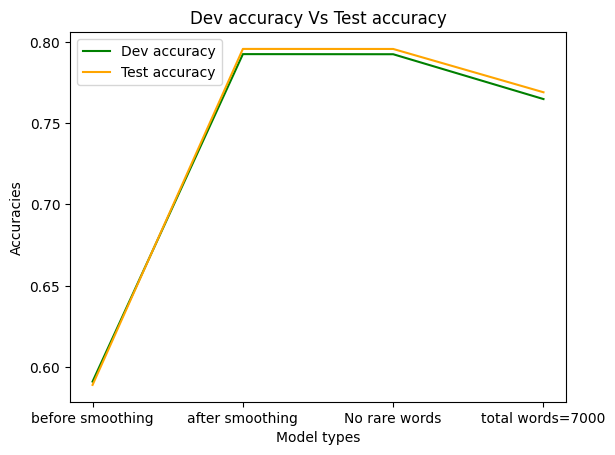

In [ ]:
accuracies_dev=[0.5911111111111111,0.7924583333333334, 0.7923888888888889, 0.7648194444444445]
accuracies_test=[0.5890416666666667,0.7956547619047619, 0.7956309523809524,0.769]
types=["before smoothing","after smoothing","No rare words","total words=7000"]
import matplotlib.pyplot as plt
plt.title("Dev accuracy Vs Test accuracy")
plt.plot(types,accuracies_dev,'g',label="Dev accuracy")
plt.plot(types,accuracies_test,'orange',label="Test accuracy")
plt.xlabel('Model types')
plt.ylabel('Accuracies')
plt.legend()
plt.show()